In [1]:
import re
import pandas as pd
import torch
import os
import json
import numpy as np
import pickle
from statannotations.Annotator import Annotator
from pingouin import ttest, homoscedasticity, normality

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style()

In [2]:
def save_plot(path, name, fig):
    with open(path + "tikz/" + name + ".pkl", 'wb') as file:
        pickle.dump(fig, file)
    fig.savefig(path + "svg/" + name + ".svg")

In [13]:
parent_path = "../neurips/"
plot_path = "../neurips/plots/"
run = '2'
approach = "abstractbeam"
testset = "handwritten"

In [14]:
with open(parent_path + f"{approach}/ogdomain/models{run}/model-latest.ckpt", "rb") as f:
    ckpt = torch.load(f)  # , map_location=torch.device("mps"))

In [15]:
inventions = ckpt["inventions"]
for inv in inventions:
    print(inv.name, inv.program, inv.arity)

fn_0 Count((lambda v1: Greater(x1, v1)), x2) 2
fn_1 Take(-1, x1) 1
fn_2 Filter((lambda v1: Greater(v1, x1)), x2) 2


In [16]:
constants = ckpt["domain"].constants
print(f"initial constants: {[-1, 0, 1, 2, 3, 4]}")
print(f"now: {constants}")

initial constants: [-1, 0, 1, 2, 3, 4]
now: [-1, 0, 1, 2, 3, 4]


In [17]:
with open(parent_path + f"{approach}/ogdomain/results{run}/run_1.json", "rb") as json_file:
    results = json.load(json_file)
solutions = [ele for ele in results["results"] if ele["success"]]
len(solutions) / len(results["results"]) * 100

44.0

In [25]:
p = '../neurips/lambdabeam/ogdomain/models2/logs/'
for file in os.listdir(p): 
    # Initialize an event accumulator
    event_AB = EventAccumulator(p + file)
    event_AB.Reload()
    try:
        scalars = event_AB.Scalars('eval/succ')
        print(file)
    except KeyError:
        tst = 1
        # print("empty")
        # print(file)
        # os.remove(lb_file + file)

events.out.tfevents.1715853059.dws-student-01.1937098.0


[ 7.59019296 12.60043928]
[8.80147227]
43.99999976158142 43.99999976158142


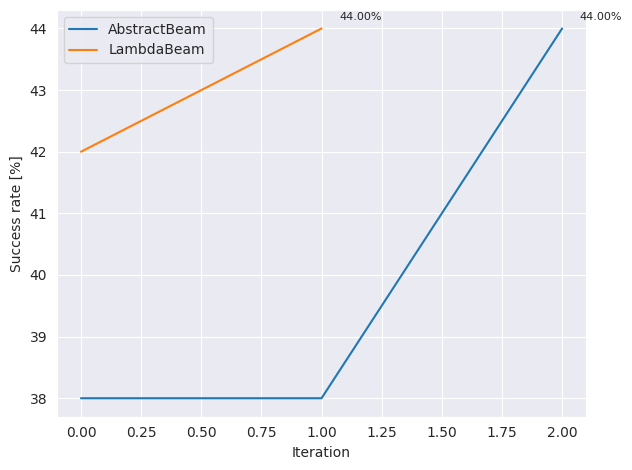

In [30]:
"""path_dict = {"abstractbeam fold 1": ["events.out.tfevents.1714053475.dws-07.3890530.0", "events.out.tfevents.1714032509.dws-07.3771435.0"],
             "abstractbeam fold 2": ["events.out.tfevents.1714457794.dws-08.391667.0", "events.out.tfevents.1715340297.dws-student-01.3676656.0", "events.out.tfevents.1715500982.dws-student-01.220501.0", "events.out.tfevents.1715599491.dws-student-01.598324.0", "events.out.tfevents.1715754350.dws-student-01.1001414.0"],
             "abstractbeam fold 1 og": ["events.out.tfevents.1714975955.dws-08.865485.0", "events.out.tfevents.1715072169.dws-08.983221.0"],
             "lambdabeam fold 1": ["events.out.tfevents.1713428257.dws-06.1874500.0", "events.out.tfevents.1713532162.dws-06.528186.0"],
             "lambdabeam fold 2": ["events.out.tfevents.1714628885.dws-06.876364.0", "events.out.tfevents.1715683029.dws-student-01.754111.0"],
             "lambdabeam fold 1 og": []
             }"""
path_dict= {
    "ab fold 1": ["events.out.tfevents.1715801783.dws-student-01.1781218.0", "events.out.tfevents.1715839068.dws-student-01.1849346.0"],
    "ab fold 2": ["events.out.tfevents.1715801919.dws-student-01.1785344.0", "events.out.tfevents.1715885186.dws-student-01.2063158.0"],
    "lb fold 1": ["events.out.tfevents.1715858660.dws-08.2976407.0"],
    "lb fold 2": ["events.out.tfevents.1715853059.dws-student-01.1937098.0"]
}
fold = 2
# Path to your event file or directory
ab_file = '../neurips/abstractbeam/ogdomain/models/logs/' if fold == 1 else '../neurips/abstractbeam/ogdomain/models2/logs/'
scalars_AB, times = [], []
for file in path_dict[f"ab fold {fold}"]: 
    # Initialize an event accumulator
    event_AB = EventAccumulator(ab_file + file)
    event_AB.Reload()
    scalars = event_AB.Scalars('eval/succ')
    times += [ele.wall_time for ele in scalars]
    scalars_AB += [ele.value for ele in scalars]
print(np.diff(np.array(times)) / 3600)
inds = np.argsort(times)
scalars_AB = np.array(scalars_AB)[inds]

lb_file = '../neurips/lambdabeam/ogdomain/models/logs/' if fold == 1 else '../neurips/lambdabeam/ogdomain/models2/logs/'
scalars_LB, times = [], []
for file in path_dict[f"lb fold {fold}"]: 
    # Initialize an event accumulator
    event_LB = EventAccumulator(lb_file + file)
    event_LB.Reload()
    try:
        scalars = event_LB.Scalars('eval/succ')
    except KeyError:
        print(file)
    times += [ele.wall_time for ele in scalars]
    scalars_LB += [ele.value for ele in scalars]
print(np.diff(np.array(times)) / 3600)
max_len = max(len(scalars_AB), len(scalars_LB))
fig, ax = plt.subplots()
df = pd.DataFrame.from_dict({"AbstractBeam": np.array(list(scalars_AB) + [np.nan] * (max_len - len(scalars_AB))) * 100, "LambdaBeam": np.array(list(scalars_LB) + [np.nan] * (max_len - len(scalars_LB))) * 100})
sns.lineplot(data=df, x=np.arange(len(df)), y=df["AbstractBeam"], label="AbstractBeam")
ax.text(len(scalars_AB) - 0.75, max(df["AbstractBeam"])+0.1, f'{max(df["AbstractBeam"]):.2f}%', ha='right', va='bottom', fontsize=8)
sns.lineplot(data=df, x=np.arange(len(df)), y=df["LambdaBeam"], label="LambdaBeam")
ax.text(len(scalars_LB) - 0.75, max(df["LambdaBeam"])+0.1, f'{max(df["LambdaBeam"]):.2f}%', ha='right', va='bottom', fontsize=8)
ax.set_ylabel("Success rate [%]")
ax.set_xlabel("Iteration")
# fig.legend()
fig.tight_layout()
# save_plot(plot_path, "performance_iteration", plt.gcf())
print(max(df["AbstractBeam"]), max(df["LambdaBeam"]))

36.0 0.0 50.0 1.7888543819998317
                     W     pval  normal
Approach                               
AbstractBeam       NaN      NaN   False
LambdaBeam    0.820835  0.11851    True
               W      pval  equal_var
levene  2.666667  0.177808       True
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AbstractBeam vs. LambdaBeam: t-test independent samples, P_val:nan t=nan


/home/jzenkner/miniconda3/envs/abstractbeam/lib/python3.8/site-packages/pingouin/distribution.py:242: UserWarning: Group AbstractBeam has less than 4 valid samples. Returning NaN.
  warnings.warn(f"Group {idx} has less than 4 valid samples. Returning NaN.")
/home/jzenkner/miniconda3/envs/abstractbeam/lib/python3.8/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,
/home/jzenkner/miniconda3/envs/abstractbeam/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/jzenkner/miniconda3/envs/abstractbeam/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= 

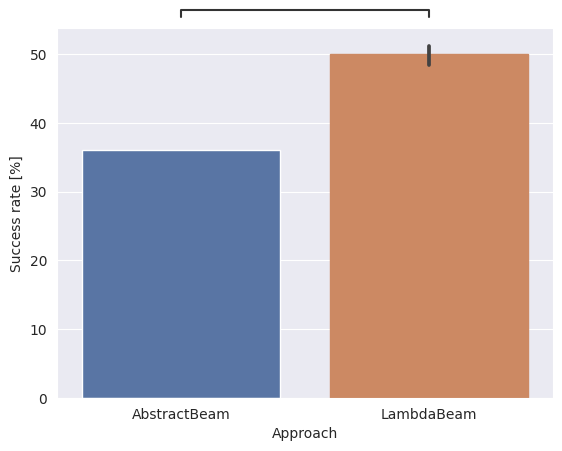

In [12]:
path = f"../neurips/abstractbeam/eval/fold2/{testset}/"
succ_ab = []
for e, file_path in enumerate(os.listdir(path)):
    with open(path + file_path) as f:
        results = json.load(f)
        l = len(results["results"])
        results = results["num_tasks_solved"]
    succ_ab.append(results / l * 100)

sns.set_palette("deep")
path = f"../neurips/lambdabeam/eval/{testset}/"
succ_lb = []
for e, file_path in enumerate(os.listdir(path)):
    with open(path + file_path) as f:
        results = json.load(f)["num_tasks_solved"]
    succ_lb.append(results / l * 100)
print(np.mean(succ_ab), np.std(succ_ab), np.mean(succ_lb), np.std(succ_lb))
df = pd.DataFrame.from_dict(
    {"Success rate [%]": succ_ab + succ_lb, "Approach": ["AbstractBeam"] * len(succ_ab) + ["LambdaBeam"] * len(succ_lb)})
ax = sns.barplot(data=df, x="Approach", y="Success rate [%]")
ax.patches[1].set_color(sns.color_palette(desat=0.75)[1])

print(normality(df, dv="Success rate [%]", group="Approach"))
print(homoscedasticity(df, dv="Success rate [%]", group="Approach"))

annotator = Annotator(ax, [("AbstractBeam", "LambdaBeam")], data=df, x="Approach", y="Success rate [%]")
annotator.configure(test='t-test_ind', text_format='star', loc='outside')
a = annotator.apply_and_annotate()
# save_plot(plot_path, f"performance_{testset}", plt.gcf())

In [13]:
from crossbeam.data.deepcoder.solution_weight import solution_weight
def load_and_process_results(file_paths, path, key="elapsed_time"):
    l = []
    for e, file_path in enumerate(file_paths):
        with open(path + file_path) as f:
            results = json.load(f)["results"]
        if key == "total_num_values_explored":
            num_programs, success = zip(*[(sol["stats"][key], sol["success"]) for sol in results if sol["stats"]["total_num_values_explored"] and sol["elapsed_time"] <= 100])
        elif key == "elapsed_time":
            num_programs, success = zip(*[(sol["elapsed_time"], sol["success"]) for sol in results if sol["elapsed_time"] and sol["elapsed_time"] <= 100])
        elif key == "Solution weight":
            num_programs, success = zip(*[(solution_weight(sol["solution"], domain=ckpt["domain"]), sol["success"]) for sol in results if sol["elapsed_time"] and sol["elapsed_time"] <= 100])
            
        sorted_data = sorted(zip(num_programs, success))
        sorted_time_taken, sorted_tasks_solved = zip(*sorted_data)
        cumulative_tasks = [sum(sorted_tasks_solved[:i+1]) / len(results) * 100 for i in range(len(sorted_tasks_solved))]
        if key == "elapsed_time":
            sorted_time_taken = list(sorted_time_taken) + [100]
            cumulative_tasks.append(cumulative_tasks[-1])
            x_key = "Elapsed time"
        elif key == "total_num_values_explored":
            sorted_time_taken = list(sorted_time_taken)
            x_key = "Number of explored values"
        elif key == "Solution weight":
            sorted_time_taken = list(sorted_time_taken)
            x_key = key
        
        l.append(pd.DataFrame.from_dict({x_key: sorted_time_taken, "Success rate [%]": cumulative_tasks}))
    if key == "Solution weight":
        return pd.concat(l).sort_values(x_key)
    dfs = pd.concat(l).sort_values(x_key)
    dfs[x_key] = dfs[x_key].rolling(window=3).mean()
    dfs = dfs.drop_duplicates(subset=[x_key])
    dfs = dfs.set_index(x_key)
    
    dfs['Moving Max'] = dfs['Success rate [%]'].rolling(window=3).max()
    dfs['Moving Min'] = dfs['Success rate [%]'].rolling(window=3).min()
    dfs['Success rate [%]'] = dfs['Success rate [%]'].rolling(window=3).mean()
    return dfs


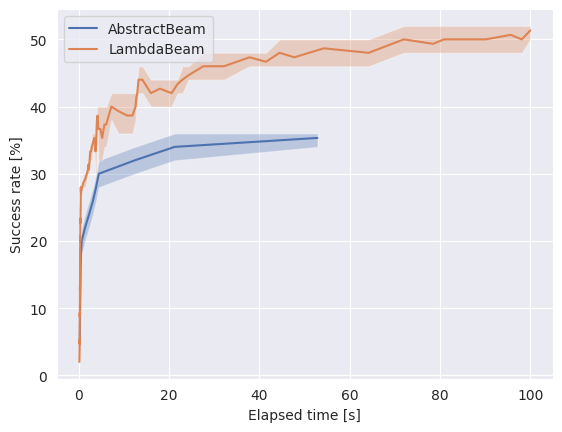

In [14]:
ax = plt.subplot()
df_ab = load_and_process_results(os.listdir(f"../neurips/abstractbeam/eval/fold2/{testset}/"), f"../neurips/abstractbeam/eval/fold2/{testset}/")
df_lb = load_and_process_results(os.listdir(f"../neurips/lambdabeam/eval/{testset}/"), f"../neurips/lambdabeam/eval/{testset}/")

sns.lineplot(data=df_ab, x="Elapsed time", y="Success rate [%]", label="AbstractBeam", ax=ax)
plt.fill_between(df_ab.index, df_ab["Moving Min"], df_ab["Moving Max"], alpha=0.3)

sns.lineplot(data=df_lb, x="Elapsed time", y="Success rate [%]", label="LambdaBeam", ax=ax)
ax.set_xlabel("Elapsed time [s]")
plt.fill_between(df_lb.index, df_lb["Moving Min"], df_lb["Moving Max"], alpha=0.3)
#save_plot(plot_path, f"performance_time_{testset}", plt.gcf())

In [ ]:
ax = plt.subplot()
df_ab = load_and_process_results(os.listdir(f"../neurips/abstractbeam/eval/fold2/{testset}/"), f"../neurips/abstractbeam/eval/fold2/{testset}/", key="total_num_values_explored")
df_lb = load_and_process_results(os.listdir(f"../neurips/lambdabeam/eval//{testset}/"), f"../neurips/lambdabeam/eval/{testset}/", key="total_num_values_explored")

sns.lineplot(data=df_ab, x="Number of explored values", y="Success rate [%]", label="AbstractBeam", ax=ax)
plt.fill_between(df_ab.index, df_ab["Moving Min"], df_ab["Moving Max"], alpha=0.3)
sns.lineplot(data=df_lb, x="Number of explored values", y="Success rate [%]", label="LambdaBeam", ax=ax)
plt.fill_between(df_lb.index, df_lb["Moving Min"], df_lb["Moving Max"], alpha=0.3)
#save_plot(plot_path, f"performance_programs_{testset}", plt.gcf())

In [ ]:
def process_data_over_length(file_paths, path, key="Success rate [%]"):
    
    df = {"Solution weight": [], key: []}
    for e, file_path in enumerate(file_paths):
        with open(path + file_path) as f:
            results = json.load(f)["results"]

        if key == "Success rate [%]":
            success = np.array([sol["success"] if sol["success"] else False for sol in results])
            x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results]
            # print([sol["task_solution"] for sol in results if solution_weight(sol["task_solution"], domain=ckpt["domain"]) == 8])
            df["Solution weight"] += x_axis
            df["Success rate [%]"] += list(success)
        elif key == "Abstraction usage [%]":
            sols = [sol for sol in results if sol["solution"]] 
            abs_used = np.array([True if "fn_" in str(sol["solution"]) or "0" in str(sol["solution"]) else False for sol in sols])
            x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in sols]
            # print([(s["solution"], weight, s["solution_weight"], np.mean(abs_used)) for s, weight in zip(sols, x_axis) if weight == 8])
            df["Solution weight"] += x_axis
            df["Abstraction usage [%]"] += list(abs_used)
        elif key == "Elapsed time [s]":
            success = np.array([sol["elapsed_time"] for sol in results]) 
            x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results]
            df["Solution weight"] += x_axis
            df["Elapsed time [s]"] += list(success)
        elif key == "Average number of used abstractions":
            success = np.array([str(sol["solution"]).count("fn_") + str(sol["solution"]).count("0") for sol in results if sol["solution"]])
            x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results if sol["solution"]]
            df["Solution weight"] += x_axis
            df["Average number of used abstractions"] += list(success)

    dfs = pd.DataFrame.from_dict(df)
    return dfs

In [ ]:
key = "Abstraction usage [%]"
testset = "handwritten"
bined_df_ab = process_data_over_length(os.listdir(f"../neurips/abstractbeam/eval/fold2/{testset}/"), f"../neurips/abstractbeam/eval/fold2/{testset}/", key=key)
bined_df_lb = process_data_over_length(os.listdir(f"../neurips/lambdabeam/eval/{testset}/"), f"../neurips/lambdabeam/eval/{testset}/", key=key)
df_merged = pd.concat([bined_df_ab, bined_df_lb], keys=['AbstractBeam', 'LambdaBeam']).reset_index()
df_merged.drop(columns="level_1", inplace=True)
df_merged.rename(columns={'level_0': 'Approach'}, inplace=True)
df_merged[key] *= 1

In [ ]:
ax = plt.subplot()
ax = sns.histplot(data=df_merged[df_merged["Abstraction usage [%]"] == 1], x="Solution weight", ax=ax, color=sns.color_palette()[0], discrete=True)

n_prog_per_len = np.array([len(df_merged[df_merged["Solution weight"] == l]) for l in range(1, 20)]) 
df_sol = df_merged[df_merged["Abstraction usage [%]"] == 1]
n_sol_per_len = np.array([len(df_sol[df_sol["Solution weight"] == l]) for l in range(1, 20)])
percentage = n_sol_per_len / n_prog_per_len * 100

ax.set_ylim(0, 20, 2)
plt.yticks(range(0, 20, 2))
for i, p in enumerate(percentage):
    if p != 0 and not np.isnan(p):
        ax.text(i + 1, 1, f"{round(p)}%", color='black', ha="center")

#save_plot(plot_path, f"performance_abstractionusage_{testset}", plt.gcf())

In [ ]:
key = "Success rate [%]"
bined_df_ab = process_data_over_length(os.listdir(f"../neurips/abstractbeam/eval/{testset}/"), f"../neurips/abstractbeam/eval/{testset}/", key=key)
bined_df_lb = process_data_over_length(os.listdir(f"../neurips/lambdabeam/eval/{testset}/"), f"../neurips/lambdabeam/eval/{testset}/", key=key)
df_merged = pd.concat([bined_df_ab, bined_df_lb], keys=['AbstractBeam', 'LambdaBeam']).reset_index()
df_merged.drop(columns="level_1", inplace=True)
df_merged.rename(columns={'level_0': 'Approach'}, inplace=True)

df_merged[key] *= 100
ax = plt.subplot()
ax.set_xlim(-0.5, 11.5)
sns.barplot(data=df_merged[df_merged["Solution weight"] < 12], x="Solution weight", y=key, hue="Approach", ax=ax)

pairs = [((i, "AbstractBeam"), (i, "LambdaBeam")) for i in range(4, 12)]
annotator.new_plot(ax, pairs, plot='barplot',
               data=df_merged, x="Solution weight", y=key, hue="Approach", hue_order=["AbstractBeam", "LambdaBeam"])
a = annotator.apply_test().annotate()
# save_plot(plot_path, f"performance_programlength_{testset}", plt.gcf())

In [ ]:
d = {f"{op}": 0 for op in ckpt["domain"].operations}
for e, file_path in enumerate(os.listdir(f"../neurips/abstractbeam/eval/fold2/{testset}/")):
    with open(f"../neurips/abstractbeam/eval/fold2/{testset}/" + file_path) as f:
        results = json.load(f)["results"]
        for sol in results:
            if sol["success"]:
                for op in ckpt["domain"].operations:
                    if str(op) in str(sol["solution"]):
                        d[f"{op}"] += 1
d = pd.DataFrame.from_dict(d, orient="index")
d = d.rename(columns={0: "AbstractBeam"})
d2 = {f"{op}": 0 for op in ckpt["domain"].operations}
for e, file_path in enumerate(os.listdir(f"../neurips/lambdabeam/eval/{testset}/")):
    with open(f"../neurips/lambdabeam/eval/{testset}/" + file_path) as f:
        results = json.load(f)["results"]
        for sol in results:
            if sol["success"]:
                for op in ckpt["domain"].operations:
                    if str(op) in str(sol["solution"]):
                        d2[f"{op}"] += 1
d2 = pd.DataFrame.from_dict(d2, orient="index")
d2 = d2.rename(columns={0: "LambdaBeam"})
d = pd.concat([d, d2], axis=1)
d = pd.DataFrame.from_dict({"Approach": ["AbstractBeam"] * len(d) + ["LambdaBeam"] * len(d2), "Count": d["AbstractBeam"].tolist() + d2["LambdaBeam"].tolist(), "Operations": list(d.index) + list(d2.index)})
d["Count"] /= 5
ax = plt.subplot()
sns.barplot(data=d, x="Operations", y="Count", ax=ax, hue="Approach")
ax.set_ylabel("Count")
ticks = plt.xticks(rotation=90)
#save_plot(plot_path, f"operation_histogram_differences", plt.gcf())

In [ ]:
d = {f"{op}": 0 for op in ckpt["domain"].operations if "fn_" not in str(op)}
for e, file_path in enumerate(os.listdir(f"../neurips/abstractbeam/eval/fold2/{testset}/")):
    with open(f"../neurips/abstractbeam/eval/fold2/{testset}/" + file_path) as f:
        results = json.load(f)["results"]
        for sol in results:
            for op in ckpt["domain"].operations:
                    if str(op) in str(sol["task_solution"]) and "fn_" not in str(op):
                        d[f"{op}"] += 1
            """if sol["success"]:
                for op in ckpt["domain"].operations:
                    if str(op) in str(sol["solution"]):
                        d[f"{op}"] += 1"""
d = pd.DataFrame.from_dict(d, orient="index")
d = d.rename(columns={0: "handwritten"})
d2 = {f"{op}": 0 for op in ckpt["domain"].operations if "fn_" not in str(op)}
for e, file_path in enumerate(os.listdir(f"../neurips/lambdabeam/eval/synthetic/")):
    with open(f"../neurips/lambdabeam/eval/synthetic/" + file_path) as f:
        results = json.load(f)["results"]
        for sol in results:
            
            for op in ckpt["domain"].operations:
                if str(op) in str(sol["task_solution"]) and "fn_" not in str(op):
                    d2[f"{op}"] += 1
            """
            if sol["success"]:
                for op in ckpt["domain"].operations:
                if str(op) in str(sol["solution"]):
                    d2[f"{op}"] += 1"""
d2 = pd.DataFrame.from_dict(d2, orient="index")
d2 = d2.rename(columns={0: "synthetic"})
d = pd.concat([d, d2], axis=1)
d = pd.DataFrame.from_dict({"Dataset": ["handwritten"] * len(d) + ["synthetic"] * len(d2), "Count": d["handwritten"].tolist() + d2["synthetic"].tolist(), "Operations": list(d.index) + list(d2.index)})
d["Count"] /= 5
ax = plt.subplot()
sns.set()
sns.barplot(data=d, x="Operations", y="Count", ax=ax, hue="Dataset")
ax.set_ylabel("Count")
ticks = plt.xticks(rotation=90)
#save_plot(plot_path, f"operation_histogram_differences", plt.gcf())

In [ ]:
bined_df_ab = process_data_over_length(os.listdir("../neurips/abstractbeam/eval/handwritten/"), "../neurips/abstractbeam/eval/handwritten/", key="Abstraction usage [%]")

ax = plt.subplot()
sns.barplot(bined_df_ab, x="Solution weight", y="Abstraction usage [%]", ax=ax)
# save_plot(plot_path, "abstraction_usage", plt.gcf())

In [ ]:
bined_df_ab = process_data_over_length(os.listdir("../neurips/abstractbeam/eval/handwritten/"), "../neurips/abstractbeam/eval/handwritten/", "Average number of used abstractions")

ax = plt.subplot()
sns.barplot(bined_df_ab, x="Solution weight", y="Average number of used abstractions", ax=ax)
# save_plot(plot_path + "abstractionusage_programlength", plt.gcf())

In [ ]:
[(inv.name, inv.program) for inv in ckpt["inventions"]] + [('0', '0')]

In [ ]:
sols = [sol["solution"] for sol in solutions if sol["solution"] and "fn_" in str(sol["solution"]) or "0" in str(sol["solution"])]
invs = [inv.name for inv in ckpt["inventions"]] + ['0']
count = {inv: 0 for inv in invs}
for inv in invs:
    for sol in sols:
        if str(inv) in str(sol):
            count[inv] += 1
count  

In [ ]:
path = "../neurips/abstractbeam/results/run_1.json"
with open(path) as f:
    results_ab = json.load(f)["results"]

path = "../neurips/lambdabeam/results/run_1.json"
with open(path) as f:
    results_lb = json.load(f)["results"]

for i in range(len(results_ab)):
    if results_ab[i]["success"] and not results_lb[i]["success"]:
        print(f"AbstractBeam solved: {results_ab[i]['solution']}, {results_ab[i]['task_solution']}")
        matches = re.findall('fn_\d+|0', results_ab[i]['solution'])
        if len(matches) > 0:
            print(rf"used abstraction(s): {matches}")
    if not results_ab[i]["success"] and results_lb[i]["success"]:
        print(f"LambdaBeam solved: {results_lb[i]['solution']}, {results_lb[i]['task_solution']}")